# Fraud Detection using Isolation Forest
### Introduction
We use the dataset of [ULB Creditcard Dataset](https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud) to train our frauld detection model. In this notebook, we will use [Isolation Forest](https://mmlspark.blob.core.windows.net/docs/0.9.1/pyspark/synapse.ml.isolationforest.html) algorithm, which refers to some execellent work listed as below:

* **Fraud detection handbook**: https://fraud-detection-handbook.github.io/fraud-detection-handbook/Foreword.html
* **AWS creditcard fraud detector**: https://github.com/awslabs/fraud-detection-using-machine-learning/blob/master/source/notebooks/sagemaker_fraud_detection.ipynb
* **Anomaly Detection using different methods**: https://www.kaggle.com/code/adepvenugopal/anomaly-detection-using-different-methods

In a fraud detection scenario, we may have very few labeled examples, and it's possible that labeling fraud takes a very long time. Isolation Forest, as an unsupervised learning algorithm, is very scalable and can help us to identify the fraud data only based on features if there is little labled data.

In [1]:
import pyspark
import yaml
import argparse
import onnxmltools
import subprocess
import numpy as np
import pandas as pd
import warnings

from pyspark.sql import functions as F
from pyspark.sql.types import FloatType, DoubleType
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics


warnings.filterwarnings('ignore')
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [2]:
def init_spark():
    spark = pyspark.sql.SparkSession.builder\
            .appName("Fraud Detection-LightGBM") \
            .config("spark.executor.memory","8G") \
            .config("spark.executor.instances","4") \
            .config("spark.executor.cores", "4") \
            .config("spark.jars.packages", "com.microsoft.azure:synapseml_2.12:0.9.4") \
            .config("spark.jars.repositories", "https://mmlspark.azureedge.net/maven") \
            .getOrCreate()
    sc = spark.sparkContext
    print(sc.version)
    print(sc.applicationId)
    print(sc.uiWebUrl)
    return spark

def load_config(path):
    params = dict()
    with open(path, 'r') as stream:
        params = yaml.load(stream, Loader=yaml.FullLoader)
    return params

def read_dataset(spark, data_path):
    dataset = spark.read.format("csv")\
      .option("header",  True)\
      .option("inferSchema",  True)\
      .load(data_path)  
    return dataset

def get_vectorassembler(dataset, features='features', label='label'):
    featurizer = VectorAssembler(
        inputCols = feature_cols,
        outputCol = 'features',
        handleInvalid = 'skip'
    )
    dataset = featurizer.transform(dataset)[label, features]
    return dataset

In [3]:
!aws s3 ls s3://dmetasoul-bucket/demo/risk/ulb/

                           PRE eval_test_dataset.parquet/
                           PRE model/
2022-07-20 06:08:35  150828752 creditcard.csv
2022-07-21 07:45:38    9368900 creditcard_test.csv
2022-07-21 07:45:35   84318327 creditcard_train.csv
2022-07-21 07:45:40   92424439 creditcard_train_smote.csv


In [4]:
spark = init_spark()

https://mmlspark.azureedge.net/maven added as a remote repository with the name: repo-1
Ivy Default Cache set to: /home/spark/.ivy2/cache
The jars for the packages stored in: /home/spark/.ivy2/jars
com.microsoft.azure#synapseml_2.12 added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-8d54be4f-9427-47fb-ab2f-e5ab1ebbbc9d;1.0
	confs: [default]


:: loading settings :: url = jar:file:/opt/spark/jars/ivy-2.4.0.jar!/org/apache/ivy/core/settings/ivysettings.xml


	found com.microsoft.azure#synapseml_2.12;0.9.4 in repo-1
	found com.microsoft.azure#synapseml-core_2.12;0.9.4 in repo-1
	found org.scalactic#scalactic_2.12;3.0.5 in central
	found org.scala-lang#scala-reflect;2.12.4 in central
	found io.spray#spray-json_2.12;1.3.2 in central
	found com.jcraft#jsch;0.1.54 in central
	found org.apache.httpcomponents#httpclient;4.5.6 in central
	found org.apache.httpcomponents#httpcore;4.4.10 in central
	found commons-logging#commons-logging;1.2 in central
	found commons-codec#commons-codec;1.10 in central
	found org.apache.httpcomponents#httpmime;4.5.6 in central
	found com.linkedin.isolation-forest#isolation-forest_3.0.0_2.12;1.0.1 in central
	found com.chuusai#shapeless_2.12;2.3.2 in central
	found org.typelevel#macro-compat_2.12;1.1.1 in central
	found org.apache.spark#spark-avro_2.12;3.0.0 in central
	found org.spark-project.spark#unused;1.0.0 in central
	found org.testng#testng;6.8.8 in central
	found org.beanshell#bsh;2.0b4 in central
	found com.b

3.1.2
spark-application-1658485249752
http://10.0.50.41:4040


### Train detection model using Isolation Forest

Here we are using [Isolation Forest](https://mmlspark.blob.core.windows.net/docs/0.9.1/pyspark/synapse.ml.isolationforest.html) to train our fraud detection model. Moreover, we will test the model performance by using multiple metrics, such as AUC, KS, Balanced accuracy, Cohen's kappa and Confusion Matrix.

In [5]:
fg_train_dataset = read_dataset(spark, 's3://dmetasoul-bucket/demo/risk/ulb/creditcard_train.csv')
fg_test_dataset = read_dataset(spark, 's3://dmetasoul-bucket/demo/risk/ulb/creditcard_test.csv')

In [6]:
fg_train_dataset.printSchema()

root
 |-- Time: double (nullable = true)
 |-- V1: double (nullable = true)
 |-- V2: double (nullable = true)
 |-- V3: double (nullable = true)
 |-- V4: double (nullable = true)
 |-- V5: double (nullable = true)
 |-- V6: double (nullable = true)
 |-- V7: double (nullable = true)
 |-- V8: double (nullable = true)
 |-- V9: double (nullable = true)
 |-- V10: double (nullable = true)
 |-- V11: double (nullable = true)
 |-- V12: double (nullable = true)
 |-- V13: double (nullable = true)
 |-- V14: double (nullable = true)
 |-- V15: double (nullable = true)
 |-- V16: double (nullable = true)
 |-- V17: double (nullable = true)
 |-- V18: double (nullable = true)
 |-- V19: double (nullable = true)
 |-- V20: double (nullable = true)
 |-- V21: double (nullable = true)
 |-- V22: double (nullable = true)
 |-- V23: double (nullable = true)
 |-- V24: double (nullable = true)
 |-- V25: double (nullable = true)
 |-- V26: double (nullable = true)
 |-- V27: double (nullable = true)
 |-- V28: double (nulla

In [7]:
feature_cols = fg_train_dataset.columns[:-1]
feature_cols

['Time',
 'V1',
 'V2',
 'V3',
 'V4',
 'V5',
 'V6',
 'V7',
 'V8',
 'V9',
 'V10',
 'V11',
 'V12',
 'V13',
 'V14',
 'V15',
 'V16',
 'V17',
 'V18',
 'V19',
 'V20',
 'V21',
 'V22',
 'V23',
 'V24',
 'V25',
 'V26',
 'V27',
 'V28',
 'Amount']

In [8]:
label_col = fg_train_dataset.columns[-1]
label_col

'Class'

In [9]:
train_data = get_vectorassembler(fg_train_dataset, label=label_col, features='features')
test_data = get_vectorassembler(fg_test_dataset, label=label_col, features='features')

In [10]:
train_data.limit(10).toPandas()

22/07/22 10:21:06 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


,Class,features
0,0.0,"[28515.0, 1.2266432, 0.10198813, -0.08707244, ..."
1,0.0,"[83125.0, 1.1248479, 0.12560174, 0.2499616, 0...."
2,0.0,"[75537.0, -0.30790162, 1.0037148, 1.4042773, 0..."
3,0.0,"[156358.0, 2.1749187, -1.5354409, -0.72642803,..."
4,0.0,"[162523.0, -2.221556, 1.2619867, 2.0476425, 4...."
5,0.0,"[113992.0, -0.33519775, 0.8713775, 0.6327032, ..."
6,0.0,"[18653.0, -1.3059778, 1.7721184, 0.7417298, 0...."
7,0.0,"[133445.0, -0.30335563, 1.1449964, -0.84363854..."
8,0.0,"[87252.0, -0.46592036, 0.6283648, 1.4495686, 4..."
9,0.0,"[40607.0, 0.2710954, -2.7204888, 0.42742714, -..."


In [11]:
train, valid = train_data.randomSplit([0.90, 0.10], seed=2022)

In [12]:
model_params = {
    'numEstimators': 100,
    'bootstrap': False,
    'maxSamples': 256,
    'maxFeatures': 1.0,
    'contamination': 0.02,
    'contaminationError': 0.02 * 0.01,
    'randomSeed': 2022
}

def train_isolationforest(train_dataset, feature_col, label_col, model_params):
    from synapse.ml.isolationforest import IsolationForest
    model = IsolationForest(featuresCol='features', predictionCol='predictedLabel', scoreCol='rawPrediction', **model_params)
    model = model.fit(train_dataset)
    return model

def evaluate(predictions, label_col, metricName="areaUnderROC"):
    evaluator = BinaryClassificationEvaluator(labelCol=label_col, metricName="areaUnderROC")
    return evaluator.evaluate(predictions)

model = train_isolationforest(train, 'features', 'Class', model_params)

In [13]:
print("train dataset prediciton:")
predictions = model.transform(train_data)
print("train dataset auc:", evaluate(predictions, label_col))

train dataset prediciton:


train dataset auc: 0.9490379546606417


In [14]:
print("validation dataset prediciton:")
predictions = model.transform(valid)
print("validation dataset auc:", evaluate(predictions, label_col))

validation dataset prediciton:


validation dataset auc: 0.9882100909197331


In [15]:
model = train_isolationforest(train_data, 'features', 'Class', model_params)

22/07/22 10:21:23 WARN IsolationForest: Observed contamination is 0.020200837995365276, which is outside the expected range of 0.02 +/- 2.0E-4. If this is acceptable to you, then it is OK to proceed. If there is a very large discrepancy between observed and expected values, then please try retraining the model with an exact threshold calculation (set the contaminationError parameter value to 0.0).


In [16]:
print("test dataset prediciton:")
predictions = model.transform(test_data)
print("test dataset auc:", evaluate(predictions, label_col))

test dataset prediciton:


test dataset auc: 0.9772505561884095


In [17]:
predictionAndLabels = predictions.select('prediction', F.col(label_col).cast(DoubleType()))\
                                 .withColumnRenamed(label_col, 'label')
metrics = MulticlassMetrics(predictionAndLabels.rdd)

<AxesSubplot:>

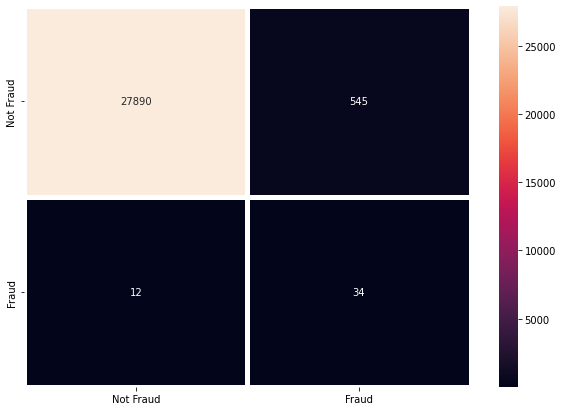

In [18]:
import matplotlib.pyplot as plt
import seaborn as sn
plt.figure(figsize = (10,7))
sn.heatmap(metrics.confusionMatrix().toArray(), 
           xticklabels=['Not Fraud', 'Fraud'],
           yticklabels=['Not Fraud', 'Fraud'],
           linewidths=5, fmt='g', annot=True)

label:  [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
prediction:  [0.70899626 0.44558525 0.38598698 0.38934759 0.38030204 0.41974639
 0.37652161 0.40660241 0.40481785 0.50283555]
KS statistic:  0.8603672754795453


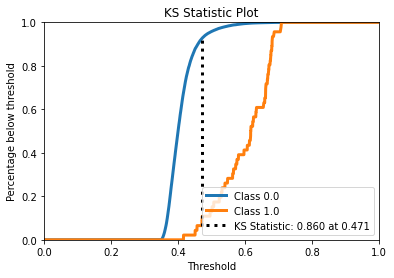

In [19]:
import sys
import matplotlib.pyplot as plt

sys.path.append('../../') 
from common.ks_utils import ks_2samp, ks_curve

label = np.array(predictions.select(label_col).collect()).reshape(-1).astype(np.float32)
prediction = np.array(predictions.select('rawPrediction').collect())[:, 0].reshape(-1)
print('label: ', label[0:10])
print('prediction: ', prediction[0:10])

ks = ks_2samp(label, prediction)
print("KS statistic: ", ks.statistic)
ks_curve(label, prediction)
plt.show()

In [20]:
from sklearn.metrics import balanced_accuracy_score, cohen_kappa_score

# scikit-learn expects 0/1 predictions, so we threshold our raw predictions
y_preds = np.where(prediction > 0.5, 1, 0)
print("Balanced accuracy = {}".format(balanced_accuracy_score(label, y_preds)))
print("Cohen's Kappa = {}".format(cohen_kappa_score(label, y_preds)))

Balanced accuracy = 0.9136642686217995
Cohen's Kappa = 0.05922978034871906


In [21]:
spark.stop()

22/07/22 10:21:48 WARN ExecutorPodsWatchSnapshotSource: Kubernetes client has been closed (this is expected if the application is shutting down.)
